[1] "merge_train_and_test_dataframe"

[1] "merge_train_and_test_dataframe"

[1] "drop_variable_before_preparation"

[1] "drop_variable_before_preparation"

[1] "clean_data"

[1] "clean_data"

[1] "numerical_feature_logical"

[1] "numerical_feature_logical"

[1] "extract_numerical_features"

[1] "extract_numerical_features"

[1] "extract_non_numerical_features"

[1] "extract_non_numerical_features"

[1] "encode_labels_in_numeric_format"

[1] "encode_labels_in_numeric_format"

[1] "one_hot_encoder"

[1] "one_hot_encoder"

[1] "feature_mapping_to_numerical_values"

[1] "feature_mapping_to_numerical_values"

[1] "feature_names_num"

[1] "feature_names_num"

[1] "drop_features_num"

[1] "drop_features_num"

[1] "get_is_one_hot_encoder"

[1] "get_is_one_hot_encoder"

[1] "set_is_one_hot_encoder"

[1] "set_is_one_hot_encoder"

[1] "skew_correction"

[1] "skew_correction"

[1] "skew_correction"

[1] "feature_engineering"

[1] "feature_engineering"

[1] "feature_scaling"

[1] "feature_scaling"

[1] "plot_histogram"

[1] "plot_histogram"

[1] "plot_function"

[1] "plot_function"

[1] "plot_density"

[1] "plot_density"

[1] "prepare_data"

[1] "prepare_data"

[1] "Alley"       "FireplaceQu" "PoolQC"      "Fence"       "MiscFeature"
       PoolQC   MiscFeature         Alley         Fence   FireplaceQu 
         2909          2814          2721          2348          1420 
  LotFrontage   GarageYrBlt  GarageFinish    GarageQual    GarageCond 
          486           159           159           159           159 
   GarageType      BsmtCond  BsmtExposure      BsmtQual  BsmtFinType2 
          157            82            82            81            80 
 BsmtFinType1    MasVnrType    MasVnrArea      MSZoning     Utilities 
           79            24            23             4             2 
 BsmtFullBath  BsmtHalfBath    Functional   Exterior1st   Exterior2nd 
            2             2             2             1             1 
   BsmtFinSF1    BsmtFinSF2     BsmtUnfSF   TotalBsmtSF    Electrical 
            1             1             1             1             1 
  KitchenQual    GarageCars    GarageArea      SaleType    MSSubClass 
   

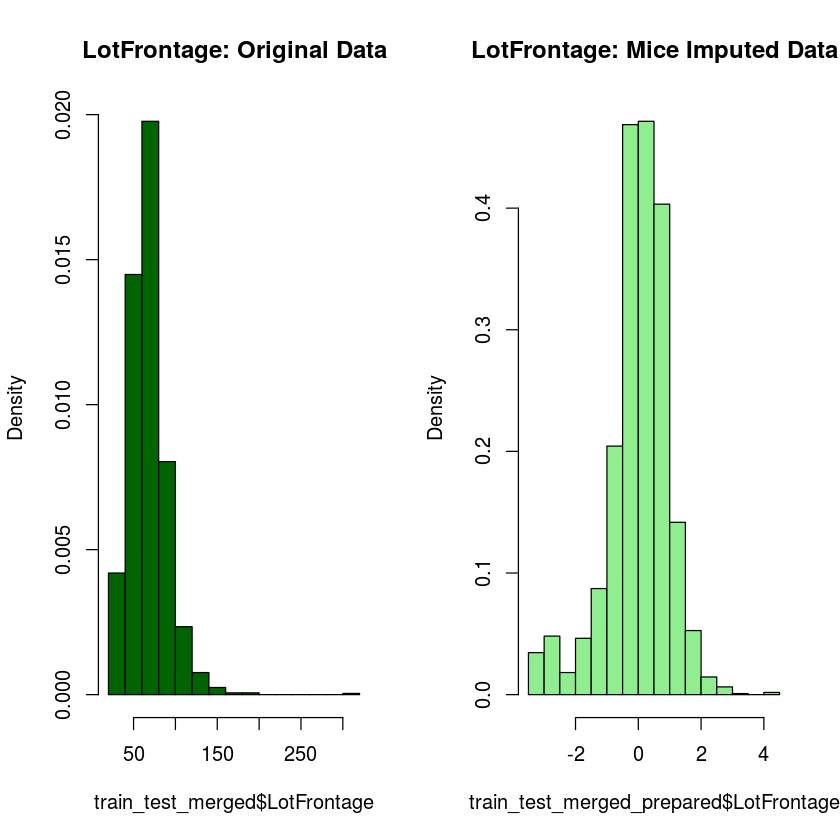

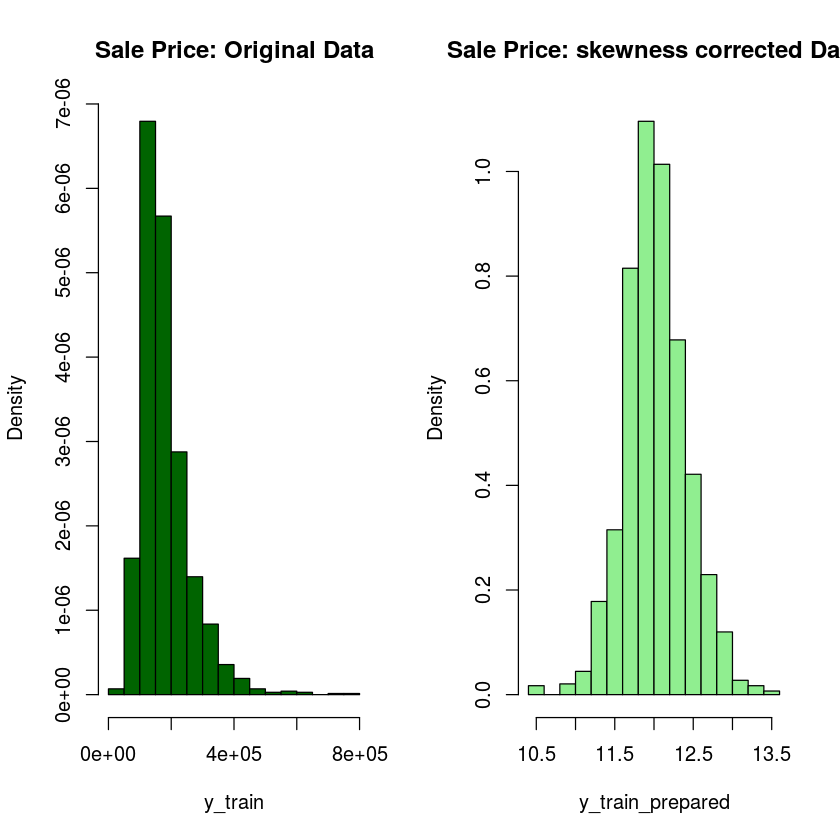

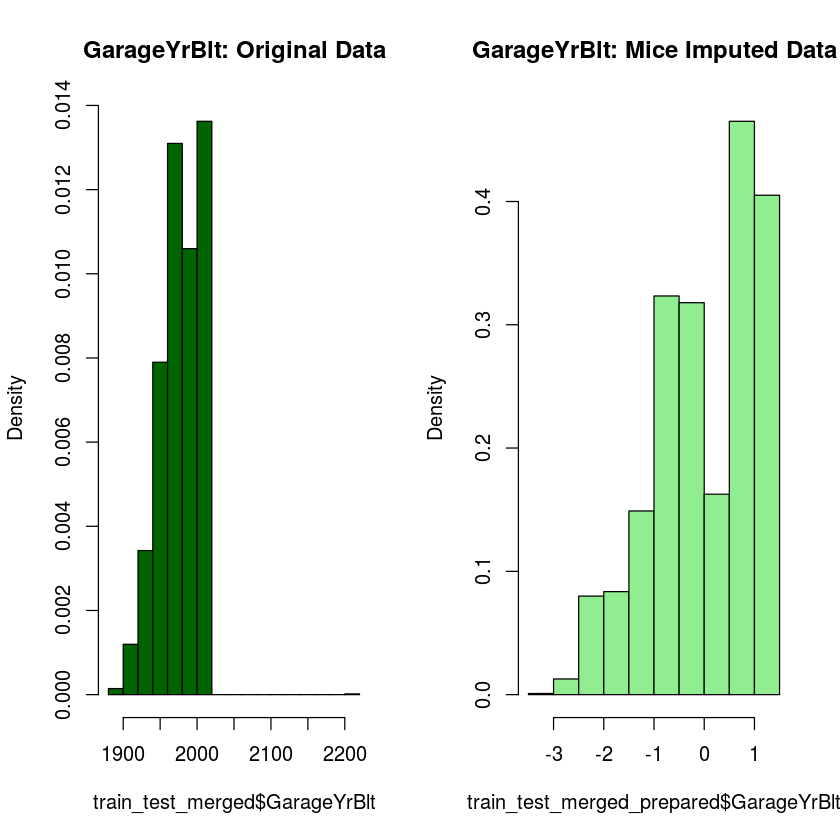

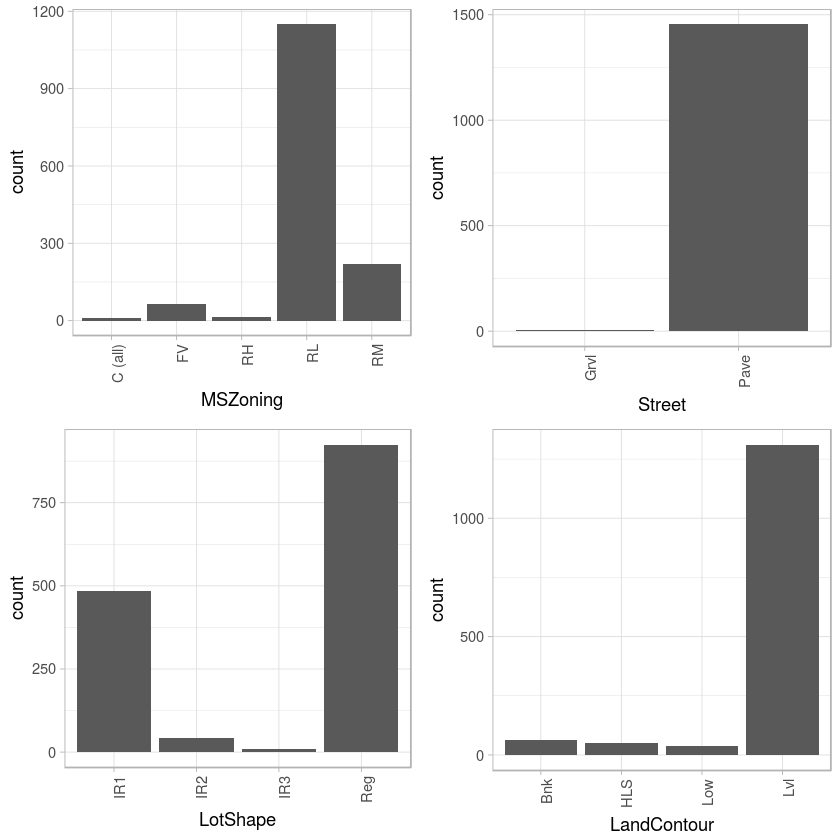

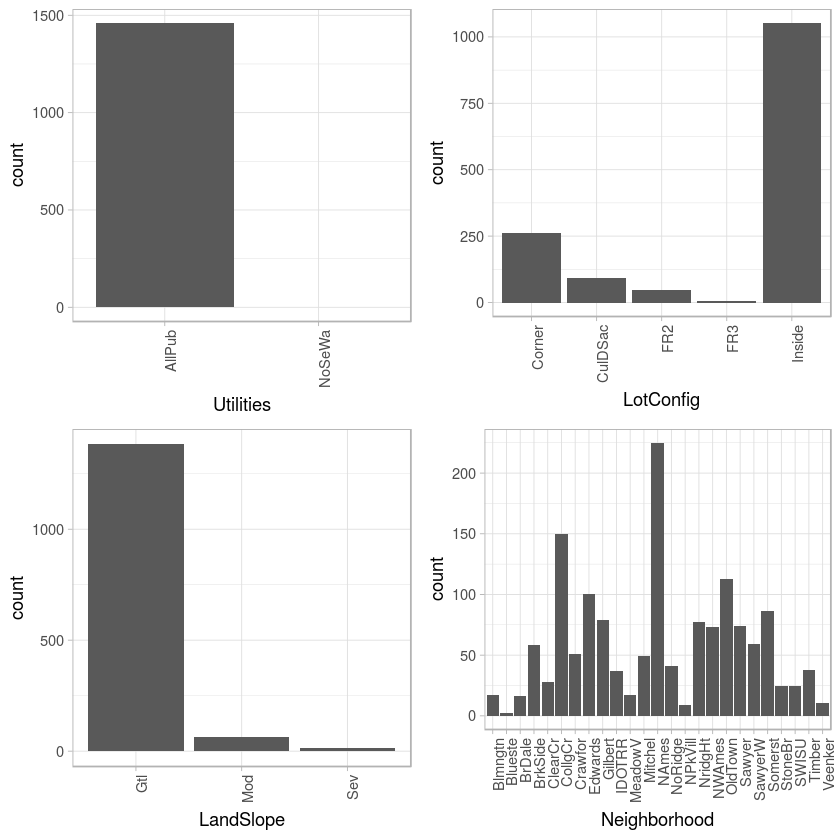

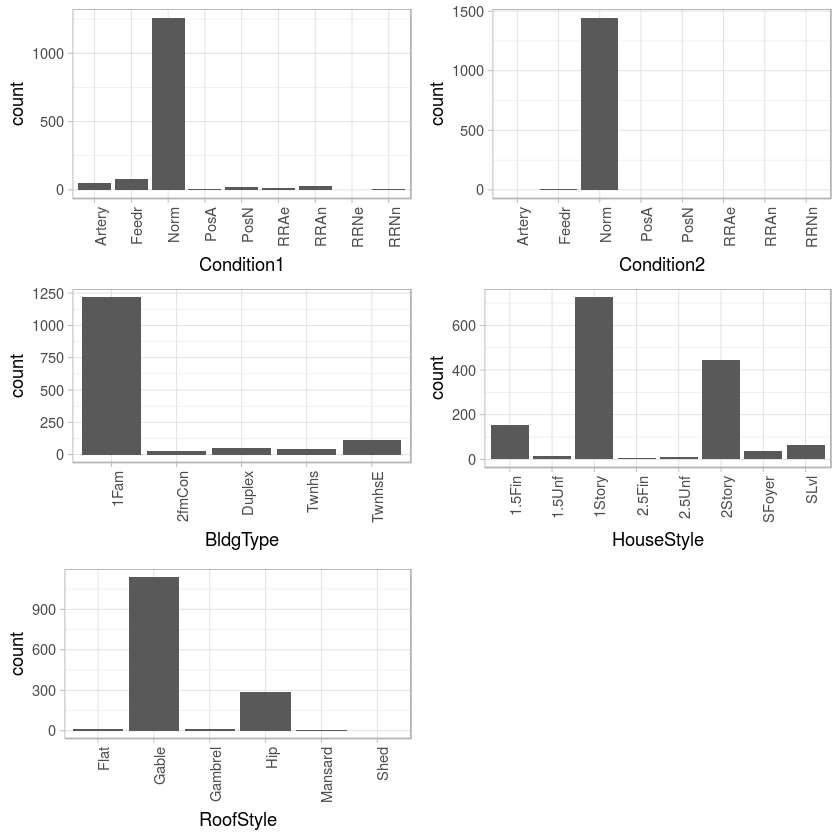

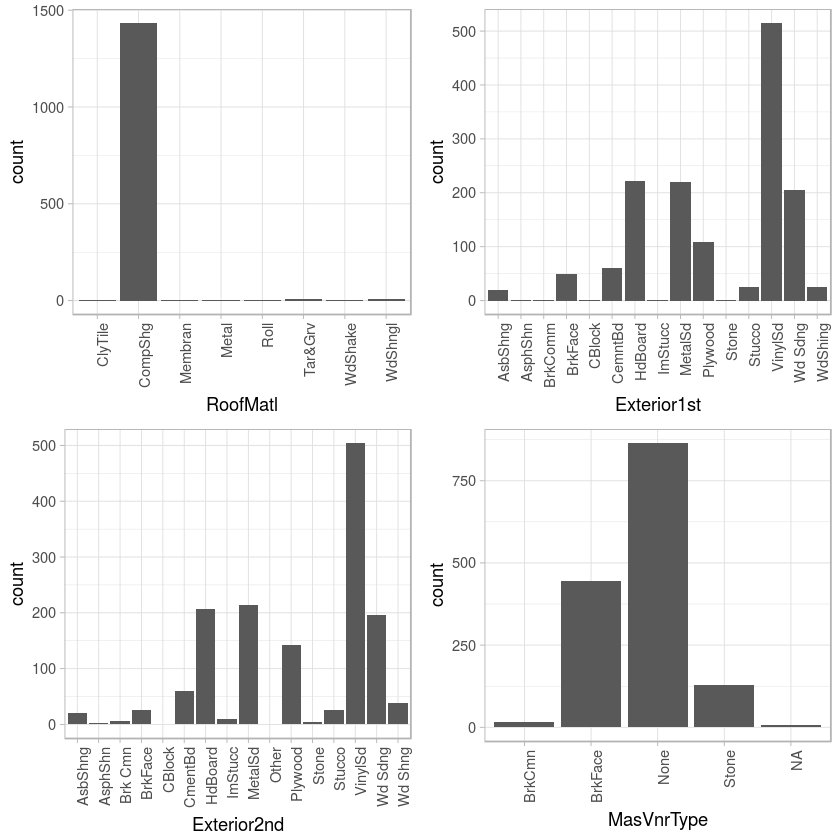

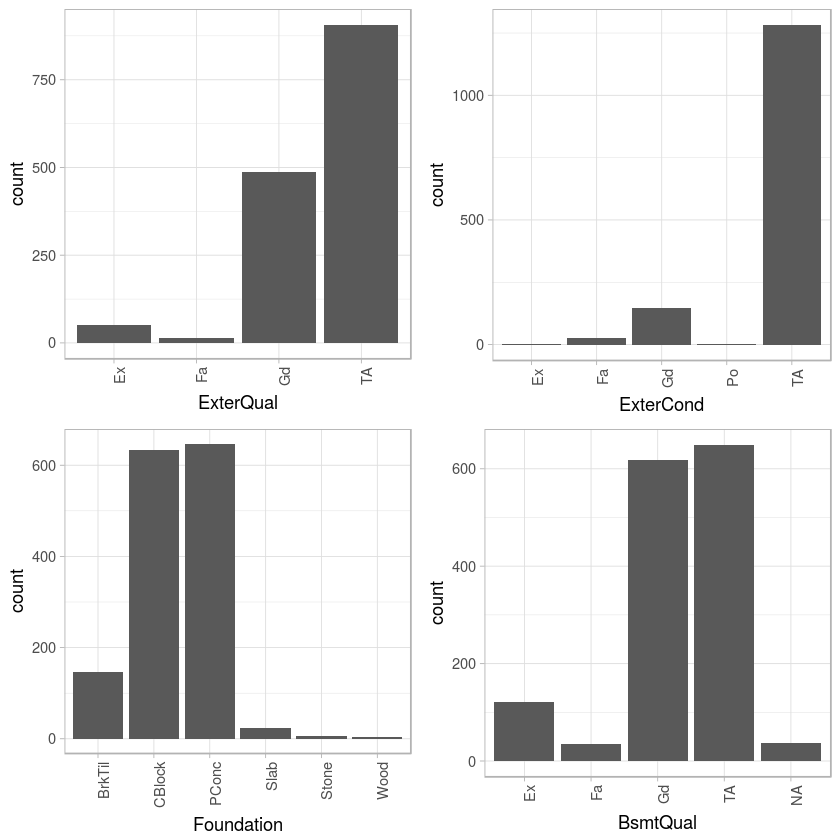

In [2]:
library(data.table)
library(xgboost)
library(Metrics)
library(Matrix)
library(mice)
library(dplyr)
library('ggplot2')
library('ggthemes')
library('scales')
library(bit64)  # may be needed for fread() for bit64::integer64 type properly displayed
library(moments)  # imports skewness
library(caret)
library(gridExtra)
library(cowplot)
library(lattice)
# library(Hmisc)  # not working
# library(Formula)
# library(VIM)

HousePrices <- setClass(
              # Set name of class
              "HousePrices",
              
              # Define slots
              slots = c(
                        df = "data.frame",
                        df_test = "data.frame",
                        # df_train_test_merged = "numeric"
                        numerical_feature_names = "character",
                        non_numerical_feature_names = "character",
                        feature_names_num = "character",
                        is_one_hot_encoder = "logical",
                        is_with_log1p_SalePrice = "logical"
                        
                        ),
              
              # Set default values
              prototype=list(
                    df = fread('/home/mizio/Documents/Kaggle/HousePrices/train.csv', showProgress = T, data.table = FALSE),
                    # df = read.csv('/home/mizio/Documents/Kaggle/HousePrices/train.csv', stringsAsFactors = T),
                    df_test = fread('/home/mizio/Documents/Kaggle/HousePrices/test.csv', showProgress = T, data.table = FALSE),
                    # df_test = read.csv('/home/mizio/Documents/Kaggle/HousePrices/test.csv', stringsAsFactors = T)
                    # y_train = df$SalePrice
                    numerical_feature_names = c(),
                    non_numerical_feature_names = c(),
                    feature_names_num = c(),
                    is_one_hot_encoder = F,
                    is_with_log1p_SalePrice = F
                    
                    # Merge training and test data together
                    # df_train_test_merged = merge_train_and_test_dataframe(df, df_test)
                    )
              )

setGeneric(name="merge_train_and_test_dataframe",
                                           def=function(theObject, df, df_test)
                                           {
                                                    standardGeneric("merge_train_and_test_dataframe")
                                           }
                                           )

setMethod(f="merge_train_and_test_dataframe",
                                          signature="HousePrices",
                                          definition=function(theObject, df, df_test)
                                          {
                                                    # Remove Id feature and SalePrice (stored in y_train)
                                                    df$Id <- NULL
                                                    df$SalePrice <- NULL
                                                    # Id_column = test_data$Id
                                                    df_test$Id <- NULL
                                                    return(rbind(df, df_test))
                                          }
                                          )

setGeneric(name="drop_variable_before_preparation",
                                         def=function(theObject, df)
                                         {
                                                    standardGeneric("drop_variable_before_preparation")
                                         }
                                         )

setMethod(f="drop_variable_before_preparation",
                                        signature="HousePrices",
                                        definition=function(theObject, df)
                                        {
                                                    # Drop features that have certain procentage of missing values considering the training data and test, 
                                                    # since they will undergo imputation together.
                                                    # print(colSums(is.na(df)))
                                                    number_of_missing_values_in_features <- colSums(is.na(df))
                                                    features_with_many_missing_values <- character(0)
                                                    features_in_df <- names(df)
                                                    for(feature in features_in_df)
                                                      {
                                                      if(number_of_missing_values_in_features[[feature]] >= 0.3*nrow(df))
                                                        {
                                                        features_with_many_missing_values <- append(features_with_many_missing_values, feature)
                                                        }
                                                      }
                                                    print(features_with_many_missing_values)
                                                    df <- df[, !(names(df) %in% features_with_many_missing_values)]
                                                    return(df)
                                        }
                                        )

setGeneric(name="clean_data",
                       def=function(theObject, df)
                       {
                                  standardGeneric("clean_data")
                       }
                       )

setMethod(f="clean_data",
                      signature="HousePrices",
                      definition=function(theObject, df)
                      {
                                  if(sum(is.na(df)) > 0)
                                  {
                                    is_with_MICE <- F
                                    if(is_with_MICE)
                                    {
                                      # Imputation with MICE
                                      set.seed(0)
                                      df <- as.data.frame(df)
                                      df_imputed <- complete(mice(df))  # method='rf'))
                                    } else
                                    {
                                      # Remove all rows with NA values
                                      df_imputed <- df[complete.cases(df),]
                                    }
                                    
                                  }
                                  return(df_imputed)
                      }
                      )

setGeneric(name="numerical_feature_logical",
                                          def=function(theObject, df)
                                          {
                                                      standardGeneric("numerical_feature_logical")
                                          }
                                          )

setMethod(f="numerical_feature_logical",
                                      signature="HousePrices",
                                      definition=function(theObject, df)
                                      {
                                                  # Numeric data types in R: 'numeric', 'integer'
                                                  numerical_features <- data.frame(logical(dim(df)[2]), row.names = names(df))
                                                  for(feature in rownames(numerical_features))
                                                  {
                                                    # if(class(df[, get(feature)]) == "numeric" || class(df[, get(feature)]) == "integer")
                                                    if(class(df[, feature]) == "numeric" || class(df[, feature]) == "integer")
                                                    {
                                                      numerical_features[feature,] = T
                                                    }
                                                  }
                                                  # Feature names with True
                                                  # browser()
                                                  return(numerical_features)
                                      }
                                      )

setGeneric(name="extract_numerical_features",
                                       def=function(theObject, numerical_features)
                                       {
                                                  standardGeneric("extract_numerical_features")
                                       }
                                       )

setMethod(f="extract_numerical_features",
                                      signature="HousePrices",
                                      definition=function(theObject, numerical_features)
                                      {
                                                  mask_index <- which(numerical_features$logical.dim.df..2..)
                                                  return(rownames(numerical_features)[mask_index])
                                      }
                                      )

setGeneric(name="extract_non_numerical_features",
                                             def=function(theObject, numerical_features)
                                             {
                                                        standardGeneric("extract_non_numerical_features")
                                             }
                                             )

setMethod(f="extract_non_numerical_features",
                                          signature="HousePrices",
                                          definition=function(theObject, numerical_features)
                                          {
                                                        mask_index <- which(numerical_features$logical.dim.df..2.. == F)
                                                        return(rownames(numerical_features)[mask_index])
                                          }
                                          )

setGeneric(name="encode_labels_in_numeric_format",
           def=function(theObject, df, feature)
           {
                      standardGeneric("encode_labels_in_numeric_format")
           }
           )
setMethod(f="encode_labels_in_numeric_format",
          signature="HousePrices",
          definition=function(theObject, df, feature)
          {
            # Encode categorical features as integers
            # browser()
            feature_name_num <- paste0(feature, 'Num', collapse='')
            levels <- sort(unique(df[[feature]]))
            df[[feature_name_num]] <- as.integer(factor(df[[feature]], levels=levels))
            return(df)
          }
          )

setGeneric(name="one_hot_encoder",
                             def=function(theObject, df, feature)
                             {
                                        standardGeneric("one_hot_encoder")
                             }
                             )

setMethod(f="one_hot_encoder",
                          signature="HousePrices",
                          definition=function(theObject, df, feature)
                          {
                            levels <- sort(unique(df[[feature]]))
                            levels_num <- lapply(levels, function(x) paste0(feature, x, collapse=''))
                            feature_num <- paste0(feature, 'Num', collapse='')
                            ith <- 1
                            # browser()
                            for(level in levels_num)
                            {
                              df[level] <- as.integer(df[feature_num] == ith)
                              ith <- ith + 1
                            }
                            
                            # df_all_dummy <- acm.disjonctif(df[feature])
                            # df[feature] <- NULL
                            # df <- cbind(df, df_all_dummy)
                            return(df)
                            
                          }
                          )

setGeneric(name="feature_mapping_to_numerical_values",
                                                   def=function(theObject, df)
                                                   {
                                                              standardGeneric("feature_mapping_to_numerical_values")
                                                   }
                                                   )

setMethod(f="feature_mapping_to_numerical_values",
                                              signature="HousePrices",
                                              definition=function(theObject, df)
                                              {
                                                ith <- 1
                                                for(feature in theObject@non_numerical_feature_names)
                                                {
                                                  df <- encode_labels_in_numeric_format(theObject, df, feature)
                                                  
                                                  if(theObject@is_one_hot_encoder)
                                                  {
                                                    df <- one_hot_encoder(theObject, df, feature)
                                                  }
                                                }
                                                return(df)
                                              }
                                              )

setGeneric(name="feature_names_num",
           def=function(theObject, df)
           {
             standardGeneric("feature_names_num")
           }
           )

setMethod(f="feature_names_num",
          signature="HousePrices",
          definition=function(theObject, df)
          {
            feature_names_num <- vector("character", length=length(theObject@non_numerical_feature_names))
            ith <- 1
            for(feature in theObject@non_numerical_feature_names)
            {
              feature_name_num <- paste0(feature, 'Num', collapse='')
              feature_names_num[ith] <- feature_name_num
              ith = ith + 1
            }
            return(feature_names_num)
          }
          )

setGeneric(name="drop_features_num",
           def=function(theObject, df)
           {
             standardGeneric("drop_features_num")
           }
           )

setMethod(f="drop_features_num",
          signature="HousePrices",
          definition=function(theObject, df)
          {
            df <- df[, !(names(df) %in% theObject@feature_names_num)]
            return(df)
          }
          )

setGeneric(name="get_is_one_hot_encoder",
                                     def=function(theObject)
                                     {
                                                standarGeneric("get_is_one_hot_encoder")
                                     }
                                     )

setMethod(f="get_is_one_hot_encoder",
                                  signature="HousePrices",
                                  definition=function(theObject)
                                  {
                                    return(theObject@is_one_hot_encoder)
                                  }
                                  )

setGeneric(name="set_is_one_hot_encoder",
                                     def=function(theObject, is_one_hot_encoder)
                                     {
                                       standarGeneric("set_is_one_hot_encoder")
                                     }
                                     )

setMethod(f="set_is_one_hot_encoder",
                                  signature="HousePrices",
                                  definition=function(theObject, is_one_hot_encoder)
                                  {
                                    theObject@is_one_hot_encoder <- is_one_hot_encoder
                                    return(theObject)
                                  }
                                  )

setGeneric(name="skew_correction",
           def=function(theObject, df)
           {
             standardGeneric("skew_correction")
           }
           )

setMethod(f="skew_correction",
          signature=c("HousePrices", "data.frame"),
          definition=function(theObject, df)
          {
            skewed_feats <- lapply(df, function(x) skewness(x[!is.na(x)]))  # compute skewness
            skewed_feats <- skewed_feats[skewed_feats > 0.75]
            skewed_feats = names(skewed_feats)
            df[, skewed_feats] <- log1p(df[skewed_feats])
            return(df)
          }
          )

setMethod(f="skew_correction",
          signature=c("HousePrices", "integer"),
          definition=function(theObject, df)
          {
            # browser()
            is_skewed_feat <- skewness(df) > 0.75  # compute skewness
            if(is_skewed_feat)
            {
              df <- log1p(df)
            }
            return(df)
          }
          )

setGeneric(name="feature_engineering",
           def=function(theObject, df)
           {
             standardGeneric("feature_engineering")
           }
           )

setMethod(f="feature_engineering",
          signature="HousePrices",
          definition=function(theObject, df)
          {
            is_skewness_correction_for_all_features <-  1
            if(is_skewness_correction_for_all_features)
            {
              # Correcting for skewness
              # Treat all numerical variables that were not one-hot encoded
              numerical_feature_names_of_non_modified_df <- theObject@numerical_feature_names
              if(!(theObject@is_one_hot_encoder))
              {
                numerical_feature_names_of_non_modified_df <- c(theObject@feature_names_num, 
                                                                numerical_feature_names_of_non_modified_df)
              }
              relevant_features <- numerical_feature_names_of_non_modified_df
              df[, relevant_features] <- skew_correction(theObject, df[, relevant_features])
            } else
            {
                # Only scale down sale price and leave other numerical features standardized.
                if(any(names(df) %in% 'SalePrice'))
                {
                  df$SalePrice <- log1p(df$SalePrice)
                }
            }
            return(df)
          }
          )

setGeneric(name="feature_scaling",
           def=function(theObject, df)
           {
             standardGeneric("feature_scaling")
           }
           )

setMethod(f="feature_scaling",
          signature="HousePrices",
          definition=function(theObject, df)
          {
            is_scaling_for_all_features <-  1
            if(is_scaling_for_all_features)
            {
              # Correcting for skewness
              # Treat all numerical variables that were not one-hot encoded
              numerical_feature_names_of_non_modified_df <- theObject@numerical_feature_names
              if(!(theObject@is_one_hot_encoder))
              {
                numerical_feature_names_of_non_modified_df <- c(theObject@feature_names_num, 
                                                                numerical_feature_names_of_non_modified_df)
              }
              relevant_features <- numerical_feature_names_of_non_modified_df
              df[, relevant_features] <- scale(df[, relevant_features])
            } else
            {
              # Only scale down sale price and leave other numerical features standardized.
              if(any(names(df) %in% 'SalePrice'))
              {
                df$SalePrice <- scale(df$SalePrice)
              }
            }
            return(df)
          }
          )

setGeneric(name="plot_histogram",
           def=function(theObject, df, feature_col_index)
           {
             standardGeneric("plot_histogram")
           }
           )

setMethod(f="plot_histogram",
          signature="HousePrices",
          definition=function(theObject, df, feature_col_index)
          {
            return(ggplot(data=df[feature_col_index], aes(x=factor(df[[feature_col_index]]))) + 
                     stat_count() + xlab(colnames(df[feature_col_index])) + theme_light() + theme(axis.text.x=element_text(angle=90, hjust=1)))
          }
          )

setGeneric(name="plot_function",
           def=function(theObject, df, function_to_plot, feature_column_indices, ncol=2)
           {
             standardGeneric("plot_function")
           }
           )

setMethod(f="plot_function",
          signature="HousePrices",
          definition=function(theObject, df, function_to_plot, feature_column_indices, ncol=2)
          {
            feature_plots <- list()
            for(ite in feature_column_indices)
            {
              feature_plot <- function_to_plot(theObject, df=df, feature_col_index=ite)
              feature_plots <- c(feature_plots, list(feature_plot))
            }
            do.call("grid.arrange", c(feature_plots, ncol=ncol))
          }
          )

setGeneric(name="plot_density",
           def=function(theObject, df, feature_col_index, target_column_name)
           {
             standardGeneric("plot_density")
           }
           )

setMethod(f="plot_density",
          signature="HousePrices",
          definition=function(theObject, df, feature_col_index, target_column_name)
          {
            # Todo: check if commented version has error
            # df_to_plot <- data.frame(x=df[[feature_col_index]], SalePrice=df[, target_column_name])
            # feature_plot <- ggplot(data=df_to_plot) + geom_line(aes(x=df[[feature_col_index]]), stat='Sale price density', size=1, alpha=1.0) +
            #   xlab(paste0((colnames(df[[feature_col_index]])), '\n', 'Skewness: ', round(skewness(df[[feature_col_index]], na.rm=T), 2))) +
            #   theme_light()
            feature_plot <- ggplot(data=df_to_plot) + geom_line(aes(x=x), stat='Sale price density', size=1, alpha=1.0) +
              xlab(paste0((colnames(df[[feature_col_index]])), '\n', 'Skewness: ', round(skewness(df[[feature_col_index]], na.rm=T), 2))) +
              theme_light()
            return(feature_plot)
          }
          )

setGeneric(name="prepare_data",
                          def=function(theObject, df)
                          {
                                      standardGeneric("prepare_data")
                          }
                          )

setMethod(f="prepare_data", 
                        signature="HousePrices",
                        definition=function(theObject, df)
                        {
                          df <- drop_variable_before_preparation(theObject, df)
                          # browser()
                          numerical_feature_log <- numerical_feature_logical(theObject, df)
                          theObject@non_numerical_feature_names <- extract_non_numerical_features(theObject, numerical_feature_log)
                          theObject@numerical_feature_names <- extract_numerical_features(theObject, numerical_feature_log)
                          # theObject@is_one_hot_encoder <- T
                          # theObject@is_with_log1p_SalePrice <- T
                          
                          is_not_import_data <- 1
                          if(is_not_import_data)
                          {
                            # browser()
                            theObject@feature_names_num <- feature_names_num(theObject, df)
                            df <- feature_mapping_to_numerical_values(theObject, df)
                            if(theObject@is_one_hot_encoder)
                            {
                              df <- drop_features_num(theObject, df)
                            }
                            df <- feature_engineering(theObject, df)
                            df <- clean_data(theObject, df)
                            df <- feature_scaling(theObject, df)
                            # browser()
                          }
                          return(df)
                        }
                        )

# Todo: implement get and set in encapsulated form for public variables in constructor
# using ex. theObject@class_var (obs. '@' works on instance like '.' in python)

if(T)
  {
  options(error=recover, show.error.locations=TRUE, warn=2)
  
  # Create instance of class
  house_prices <- HousePrices()  # , is_with_log1p_SalePrice=T)
  house_prices@is_one_hot_encoder <- F
  house_prices@is_with_log1p_SalePrice <- T

  # house_prices <- new("HousePrices", is_one_hot_encoder=T)#, is_with_log1p_SalePrice=T)
  is.object(house_prices)
  isS4(house_prices)
  
  # Create object to load data
  df <- slot(house_prices, "df") 
  df_test <- slot(house_prices, "df_test")
  y_train <- df$SalePrice
  
  ## Prepare data
  # Merge training and test data together
  train_test_merged <- merge_train_and_test_dataframe(house_prices, df, df_test)
  # Number of rows in training data for later splitting
  rows_in_train <- nrow(df)
  features_in_train <- names(df)
  train_test_merged_prepared <- prepare_data(house_prices, train_test_merged)
  y_train_prepared <- skew_correction(house_prices, y_train)
  
  # Extracting numerical feature columns
  train_test_merged_prepared_numerical_feature_log <- numerical_feature_logical(house_prices, train_test_merged_prepared)
  train_test_merged_prepared_numerical_features <- extract_numerical_features(house_prices, train_test_merged_prepared_numerical_feature_log)
  # Extracting non numerical feature columns
  train_test_merged_prepared_non_numerical_features <- extract_non_numerical_features(house_prices, train_test_merged_prepared_numerical_feature_log)
  train_test_merged_prepared_only_categorical <- train_test_merged_prepared[, train_test_merged_prepared_non_numerical_features]
  train_test_merged_prepared <- train_test_merged_prepared[, train_test_merged_prepared_numerical_features]

  # Splitting merged data set
  x_train <- train_test_merged_prepared[1:rows_in_train,]
  x_test <- train_test_merged_prepared[(rows_in_train + 1):nrow(train_test_merged_prepared),]
  
  # Casting all types to numeric type (also integer)
  x_train[] <- lapply(x_train, as.numeric)
  x_test[] <- lapply(x_test, as.numeric)
  
  is_explore_data <- T
  if(is_explore_data)
  {
    # Information of df before preperation
    print(sort(sapply(train_test_merged, function(x) sum(is.na(x))), decreasing = TRUE))
    # print(colSums(is.na(train_test_merged)))
    print(summary(train_test_merged))
    
    # Check df after preparation
    print('After preperation =================')
    print(colSums(is.na(train_test_merged_prepared)))
    print(summary(train_test_merged_prepared))
    
    print(cat('Train has', dim(df)[1], 'rows and', dim(df)[2], 'columns.'))
    print(cat('Test has', dim(df_test)[1], 'rows and', dim(df_test)[2], ' columns.'))
    
    # The percentage of data missing in train.
    sum(is.na(df)) / (nrow(df) *ncol(df))
    
    # The percentage of data missing in test.
    sum(is.na(df_test)) / (nrow(df_test) * ncol(df_test))
    
    # Check if any duplicate rows
    cat("The number of row duplicates:", nrow(df) - nrow(unique(df)))
    
    # Check how distributions change after imputation
    # Plot LotFrontage price distributions
    par(mfrow=c(1,2))
    hist(train_test_merged$LotFrontage, freq=F, main='LotFrontage: Original Data', 
         col='darkgreen')
    hist(train_test_merged_prepared$LotFrontage, freq=F, main='LotFrontage: Mice Imputed Data', 
         col='lightgreen')
    
    # Check how distributions change after imputation
    # Plot LotFrontage price distributions
    par(mfrow=c(1,2))
    hist(y_train, freq=F, main='Sale Price: Original Data', 
         col='darkgreen')
    hist(y_train_prepared, freq=F, main='Sale Price: skewness corrected Data', 
         col='lightgreen')
    
    # Plot GarageYrBlt price distributions
    par(mfrow=c(1,2))
    hist(train_test_merged$GarageYrBlt, freq=F, main='GarageYrBlt: Original Data', 
         col='darkgreen')
    hist(train_test_merged_prepared$GarageYrBlt, freq=F, main='GarageYrBlt: Mice Imputed Data', 
         col='lightgreen')
    
    is_clustering <- 0
    if(is_clustering)
    {
      hel =1
      # train_test_merged_prepared_clustered <- varclus(x_train, similarity="spearman", minlev=0.05)
      # train_test_merged_prepared_clustered <- varclus(as.matrix(train_test_merged_prepared), similarity="spearman", minlev=0.05)
      # plot(train_test_merged_prepared_clustered, cex=0.5)
    }
    
    
    is_categorical_feature_plots <- T
    if(is_categorical_feature_plots)
    {
      # Todo: implement categorical feature plots
      
      #Bar plots
      # Categorical features are in total 38
      plot_function(house_prices, df[, train_test_merged_prepared_non_numerical_features], plot_histogram, 1:4, 2)
      plot_function(house_prices, df[, train_test_merged_prepared_non_numerical_features], plot_histogram, 5:8, 2)
      plot_function(house_prices, df[, train_test_merged_prepared_non_numerical_features], plot_histogram, 9:13, 2)
      plot_function(house_prices, df[, train_test_merged_prepared_non_numerical_features], plot_histogram, 14:17, 2)
      plot_function(house_prices, df[, train_test_merged_prepared_non_numerical_features], plot_histogram, 18:21, 2)
    }
    
  }
  
  
  is_test_functions <- F
  if(is_test_functions)
  {
    # Testing functions
    # numerical_feature_log <- numerical_feature_logical(house_prices, df)
    # df_num <- extract_numerical_features(house_prices, numerical_feature_log)
  }
  
  is_make_prediction <- F
  if(is_make_prediction)
  {
    
    is_xgb_cv <- T
    if(is_xgb_cv)
    {
      # --- xgboost ---
      save_path <- '/home/mizio/Documents/Kaggle/HousePrices/submission/'
      dtrain <- xgb.DMatrix(as.matrix(x_train), label=y_train_prepared)
      dtest <- xgb.DMatrix(as.matrix(x_test))
      
      # Saving xgb.DMatrix
      xgb.DMatrix.save(dtrain, paste0(save_path, "dtrain.buffer", collapse=''))
      xgb.DMatrix.save(dtest, paste0(save_path, "dtest.buffer", collapse=''))
      # Loading xgb.DMatrix
      # dtrain2 <- xgb.DMatrix(paste0(save_path, "dtrain.buffer", collapse=''))
      # dtest2 <-  xgb.DMatrix(paste0(save_path, "dtest.buffer", collapse=''))
      
      # Params aggressive and prone to overfitting
      # xgb_params <- list(
      #   seed = 0,
      #   colsample_bytree = 0.8,
      #   silent = 1,
      #   subsample = 0.6,
      #   # learning_rate = 0.01,
      #   eta = 0.06,  # low value means it is more robust to overfitting
      #   # objective = 'reg:linear',
      #   max_depth = 15,
      #   num_parallel_tree = 1,
      #   # alpha = 1,
      #   gamma = 0,
      #   min_child_weight = 0.1,
      #   eval_metric = 'rmse',
      #   booster = 'gbtree'
      #   # booster = 'gblinear'
      # )
      
      # Params conservative
      xgb_params <- list(
        seed = 0,
        colsample_bytree = 0.8,
        silent = 1,
        subsample = 0.6,
        # learning_rate = 0.01,
        eta = 0.02,  # low value means it is more robust to overfitting
        # objective = 'reg:linear',
        max_depth = 15,
        num_parallel_tree = 100,
        # alpha = 1,
        gamma = 0,
        min_child_weight = 1,
        eval_metric = 'rmse',
        booster = 'gbtree'
        # booster = 'gblinear'
        # verbose_eval=10
      )
      
      xgb_cv <- xgb.cv(xgb_params, dtrain, nrounds=1000, nfold=5, stratified=F, early_stopping_rounds=100, verbose=2)
      
      best_nrounds <- xgb_cv$best_ntreelimit
      
      # Measure learning progress while building the model
      set.seed(3410)
      train_partition_index <- createDataPartition(y_train_prepared, p=0.8, list=F, times=1)
      # dtrain_bench = dtrain[1:as.integer(dim(dtrain)[1]*0.8)]
      # dtest_bench = dtrain[(as.integer(dim(dtrain)[1]*0.8) + 1):dim(dtrain)[1]]
      dtrain_bench = dtrain[train_partition_index,]
      test_partition_index <- vector("logical", length=length(y_train_prepared))
      test_partition_index[train_partition_index] <- T
      test_partition_index <- which(!test_partition_index)
      dtest_bench = dtrain[test_partition_index,]
      watchlist <- list(train=dtrain_bench, test=dtest_bench)
      
      gbdt <- xgb.train(xgb_params, dtrain, nrounds=as.integer(best_nrounds))
      # gbdt <- xgb.train(xgb_params, dtrain_bench, watchlist=watchlist, nrounds=as.integer(best_nrounds))
      output_xgb_cv <- predict(gbdt, dtest)
      output <- output_xgb_cv
      
      # Information from xgb.DMatrix
      label = getinfo(dtrain, "label")
      # Only makes sense for binary classification where output is {0, 1}
      # err <- as.numeric(sum(as.integer(output_xgb_cv > 0.5) != label))/length(label)
      # print(paste("test-error=", err))
      
      # Feature importance
      importance_matrix <- xgb.importance(feature_names=colnames(x_train), model=gbdt)
      head(importance_matrix)
      # print(importance_matrix)
      xgb.plot.importance(importance_matrix=importance_matrix)
      # Deeper analysis of features
      # How to do it for a regression problem
      # importance_raw <- xgb.importance(feature_names=colnames(x_train), model=gbdt, data=x_train, label=y_train_prepared)
      # importance_clean <- importance_raw[,`:=`(Cover=NULL, Frequency=NULL)]
      
      # Checking Chi^2 between features. Higher means more correlated
      # chi2 <- chisq.test(x_train$OverallQual, y_train_prepared)
      # print(chi2)
      # chi2 <- chisq.test(x_train$GrLivArea)
      # print(chi2)
      
      # Trees from model
      # xgb.plot.tree(model=gbdt)
    }
    
    # Todo: implement Regularized linear models (lasso, ridge)
    
  }
  
  is_make_submission <- F
  if(is_make_submission && is_make_prediction)
  {
    name <- 'submission.csv'
    submission <- fread(paste0(save_path, name, collapse=''), colClasses=c("integer", "numeric"))
    
    if(is_make_prediction && is_xgb_cv)
    {
      # save model to binary local file
      xgb.save(gbdt, paste0(save_path, "xgboost.model", collapse=''))
      
      # Test to see how identical our saved model is to the original by comparison of two predictions
      # load binary model to R
      # bst2 <- xgb.load(paste0(save_path, "model_to_compare_xgboost.model", collapse=''))
      # pred2 <- predict(bst2, dtest)
      
      # And now the test
      # print(paste("sum(abs(pred2 - pred))=", sum(abs(pred2 - output_xgb_cv))))
    }
    
    if(house_prices@is_with_log1p_SalePrice)
    {
      submission$SalePrice <- expm1(output)
    } else
    {
      submission$SalePrice <- output
    }
    
    # submission$Id <- Id_column
    write.csv(submission, paste0(save_path, name, collapse=''), row.names=F)
    
  }

  }